# RNN tutorial on PyTorch

In [0]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Goals

We will try to force the RNN to produce next point following the sin wave, given input. The sequence passed along with the input will 20 points before that point. We will experiment with hidden states and number of layers while training RNN. Let's fucking roll into this procedure.

Just like it has been said, sequence length will be 20. There is going to be one input and one output. So, we will be training RNN with the following manner:
* Generate random point
* Generate 20 previous points prior that point
* Train RNN
  * Calculate loss
  * Optimize
* See the outputs

In [0]:
def gen_data(seq_len):
  r = np.random.rand()*np.pi
  x = np.linspace(r, r+np.pi, num=seq_len)
  y = np.sin(x)
  
  return torch.Tensor(x), torch.Tensor(y)

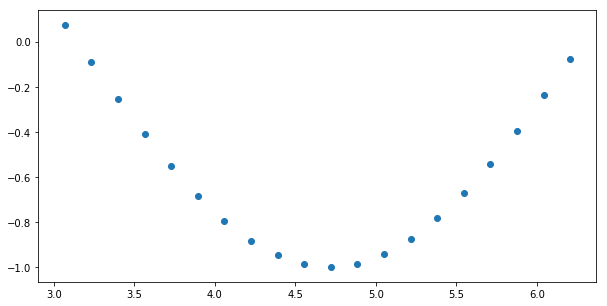

In [0]:
num_points = 20

x, y = gen_data(num_points)
x, y = x.numpy(), y.numpy()

plt.figure(figsize=(10,5))
plt.scatter(x, y)
plt.show()

## Pytorch shape regarding the RNN
Since it is explatory notebook, I will be writing my ideas regarding the shapes of inputs, outputs, general logic behind how RNN works. So, basically, RNN calculates following function:
$$
h_{t}=tanh(W_{ih}x_{t} + b_{ih} + W_{hh}h_{t-1} + b_{hh}) \\
$$
where $x_i\in R^{n\times 1}$, $W_{ih}\in R^{n\times m}$,  $h_i\in R^{m\times 1}$, $W_{hh}\in R^{m\times m}$

Pytorch's `nn.RNN` class takes in the input in the format _(seq_length, batch, input_size)_, and also initial hidden state in dimension _(num_layers*num_directions, batch ,hidden_size)_.

>__Parameters__
* __input_size__ – The number of expected features in the input x
* __hidden_size__ – The number of features in the hidden state h
* __num_layers__ – Number of recurrent layers. E.g., setting `num_layers=2` would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: `1`
* __nonlinearity__ – The non-linearity to use. Can be either `tanh` or `relu`. Default: `tanh`
* __bias__ – If `False`, then the layer does not use bias weights b_ih and b_hh. Default: `True`
* __batch_first__ – If `True`, then the input and output tensors are provided as (batch, seq, feature). Default: `False`
* __dropout__ – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
* __bidirectional__ – If `True`, becomes a bidirectional RNN. Default: `False`
>
>__Input__
* __input__ of shape _(seq_len, batch, input_size)_: tensor containing the features of the input sequence.
* __h_0__ of shape _(num_layers * num_directions, batch, hidden_size)_: tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided. If the RNN is bidirectional, `num_directions` should be 2, else it should be 1.
>
>__Output__
* __output__ of shape _(seq_len, batch, num_directions * hidden_size)_: tensor containing the output features `(h_t)` from the last layer of the RNN, for each `t`.
* __h_n__ of shape _(num_layers * num_directions, batch, hidden_size)_: tensor containing the hidden state for `t = seq_len`.

For reference, please follow this link regarding [Pytorch's `RNN class`](https://pytorch.org/docs/stable/nn.html#rnn)

In order to __outputs to make sense__, they are further __feeded to fully connected layer__ to have proper output shape. In case of __one directional RNN__, it is easy to interpret: _we have an output vector for the given item in sequence and transform it into desirable shape through fully connected layer and we do it for every item in sequence_, i.e. we have single fully connected layer to transform hidden output vector into output vector which may not make sense, if output for every single item in the sequence certainly gives different output that correlates with the sequence order.

**This point gives an idea** of training the model with RNN with fully connected layer**S**, i.e. there is going to be one fully connected layer for each position in the sequence. __But the question is what does hidden layer output, what is its meaning, speaking vaguely__?

In case of __bidirectional RNN__, the training occurs so that the future states are also taken into account when forming the hidden state for the time `t`. From [medium post](https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66):
>What bi-directional RNN does is allowing the model to see the “future”. But that “future” has to be known. Both uni-directional RNN and bi-directional RNN cannot go to the unknown future (which usually is the prediction target).

### Correction regarding the idea above

_we have an output vector for the given item in sequence and transform it into desirable shape through fully connected layer and we do it for every item in sequence_ - since hidden layer RNN is actually __recurrent__ we need to have single fully-connected layer as final layer, i.e. it simply doesn't make sense to have several FCLs: we don't know before hand the sequence len


### Note(s)
* We usually have fully connected layer in the output of the last RNN so that the output size is of the desired shape.
* `batch_first` argument only modifies the `input` and `output`, not the `hidden` state.
* __`input_size`__ is essentially `input_dimension`, i.e. __it doesn't have anything with the number of nodes__ or whatever, it is simply the __length of the input vector__

In [0]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers, verbose=False):
    super().__init__()
    
    self.hidden_dim = hidden_size
    self.verbose = verbose
    
    self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
    
  def forward(self, b_x, hidden):
    
    b_s = b_x.shape[0]

    output, hidden = self.rnn(b_x, hidden)
    
    if self.verbose:
      print('Shapes of naked RNN (output, hidden = nn.RNN(x, hidden)):')
      print(f'Output shape: {output.shape}')
      print(f'Hidden shape: {hidden.shape}')
      print('Values of the last item in sequence (output[:,-1,:] and hidden[:,0,:]):')
      print(output[:,-1,:].data)
      print(hidden[:,0,:].data)
    
    output = self.fc(output.view(b_s, -1, self.hidden_dim))
    
    return output, hidden
    
    
    

### Parameter calculation

Below is the definition of the function that will print the parameters of the model

In [0]:
def printParams(model):
  total = 0
  totalGrad = 0
  for name, param in model.named_parameters():
    total += param.numel()
    print(f'Name:{name:>20}, shape: {str(param.shape):>25}, total params: {param.numel() if param.requires_grad else 0:>10}, grad params: {param.numel() if param.requires_grad else 0:>10}')
  print(f'\nTotal number of parameters is {total}')
rnn = nn.RNN(10, 20, 2)
printParams(rnn)

Name:        weight_ih_l0, shape:      torch.Size([20, 10]), total params:        200, grad params:        200
Name:        weight_hh_l0, shape:      torch.Size([20, 20]), total params:        400, grad params:        400
Name:          bias_ih_l0, shape:          torch.Size([20]), total params:         20, grad params:         20
Name:          bias_hh_l0, shape:          torch.Size([20]), total params:         20, grad params:         20
Name:        weight_ih_l1, shape:      torch.Size([20, 20]), total params:        400, grad params:        400
Name:        weight_hh_l1, shape:      torch.Size([20, 20]), total params:        400, grad params:        400
Name:          bias_ih_l1, shape:          torch.Size([20]), total params:         20, grad params:         20
Name:          bias_hh_l1, shape:          torch.Size([20]), total params:         20, grad params:         20

Total number of parameters is 1480


The outputs of the parameters of the RNN layer is as following:
```
>>> rnn = nn.RNN(i_size, h_size, n)
>>> for name, param in rnn.named_parameters():
              print(f'Name:{name:>15}, shape: {str(param.shape):>25}, total params: {param.numel() if param.requires_grad else 0:>6}, grad params: {param.numel() if param.requires_grad else 0:>6}')
 
Name: weight_ih_l0,     shape: torch.Size([h_size, i_size]), total params: h_size*i_size, ...
Name: weight_hh_l0,     shape: torch.Size([h_size, i_size]), total params: h_size*i_size, ...
Name:   bias_ih_l0,     shape: torch.Size([h_size]),         total params: h_size, ...
Name:   bias_hh_l0,     shape: torch.Size([h_size]),         total params: h_size, ...
Name: weight_ih_l1,     shape: torch.Size([h_size, h_size]), total params: h_size*h_size, ...
Bame: weight_hh_l1,     shape: torch.Size([h_size, h_size]), total params: h_size*h_size, ...
Name:   bias_ih_l1,     shape: torch.Size([h_size]),         total params: h_size, ...
Name:   bias_hh_l1,     shape: torch.Size([h_size]),         total params: h_size, ...
...
Name: weight_ih_l[n-1], shape: torch.Size([h_size, h_size]), total params: h_size*h_size, ...
Bame: weight_hh_l[n-1], shape: torch.Size([h_size, h_size]), total params: h_size*h_size, ...
Name:   bias_ih_l[n-1], shape: torch.Size([h_size]),         total params: h_size, ...
Name:   bias_hh_l[n-1], shape: torch.Size([h_size]),         total params: h_size, ...
```
By the formulation of the RNN formulation,
$$
h_{t}=tanh(W_{ih}x_{t} + b_{ih} + W_{hh}h_{t-1} + b_{hh}) \\
$$
The corresponding values of the parameters are as follows:
* `weight_ih_ln` is $W_{ih}$ of n-th layer
* `weight_hh_ln` is $W_{hh}$ of n-th layer
* `bias_ih_ln` is $b_{ih}$ of n-th layer
* `bias_hh_ln` is $b_{hh}$ of n-th layer

Shapes of naked RNN (output, hidden = nn.RNN(x, hidden)):
Output shape: torch.Size([1, 4, 10])
Hidden shape: torch.Size([1, 1, 10])
Values of the last item in sequence (output[:,-1,:] and hidden[:,0,:]):
tensor([[-0.2069,  0.4851,  0.7408,  0.0011,  0.2334, -0.6011,  0.4831,  0.8177,
          0.1322,  0.0781]])
tensor([[-0.2069,  0.4851,  0.7408,  0.0011,  0.2334, -0.6011,  0.4831,  0.8177,
          0.1322,  0.0781]])


Shapes with FCL:
Input size: torch.Size([1, 4, 4]) (batch size, sequence length, input) correspondingly
Output size: torch.Size([1, 4, 1]) (batch size, sequence length, output) correspondingly
Hidden size: torch.Size([1, 1, 10]) (num. of layers * num. of directions, batch size, hidden size) correspondingly


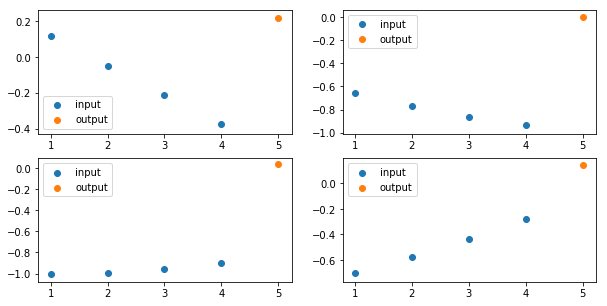

In [0]:
rnn = RNN(input_size=4, 
          hidden_size=10, 
          output_size=1, 
          n_layers=1,
          verbose=True)

x, y = gen_data(num_points)

y = y.view(4,5)

y_t = y[:, :-1].view(1, 4, 4)
y_r = y[:,-1]

y_p, hidden = rnn(y_t, None)

print('\n\nShapes with FCL:')
print(f'Input size: {str(y_t.shape)} (batch size, sequence length, input) correspondingly')
print(f'Output size: {str(y_p.shape)} (batch size, sequence length, output) correspondingly')
print(f'Hidden size: {str(hidden.shape)} (num. of layers * num. of directions, batch size, hidden size) correspondingly' )

plt.figure(figsize=(10,5))
plt.subplot(221)
plt.scatter([1,2,3,4], y_t[0,0,:].view(-1).numpy(), label='input')
plt.scatter([5], y_p.data[:,0,:].numpy(), label='output')
plt.legend()
plt.subplot(222)
plt.scatter([1,2,3,4], y_t[0,1,:].view(-1).numpy(), label='input')
plt.scatter([5], y_p.data[:,1,:].numpy(), label='output')
plt.legend()
plt.subplot(223)
plt.scatter([1,2,3,4], y_t[0,2,:].view(-1).numpy(), label='input')
plt.scatter([5], y_p.data[:,2,:].numpy(), label='output')
plt.legend()
plt.subplot(224)
plt.scatter([1,2,3,4], y_t[0,3,:].view(-1).numpy(), label='input')
plt.scatter([5], y_p.data[:,3,:].numpy(), label='output')
plt.legend()
plt.show()
 

## Training network
One thing to notice is that we have to __detach the tensor before every prediction__, so that optimizer doesn't compute gradients up until the first iteration of prediction which __might end up in vanishing or exploding gradient__ (which in turn will cause the weights to update very slightly or very greatly). Thus we detach the weights of RNN before computing the prediction for current iteration (for current batch), and then optime the weights according to difference between actual values and predictions.

Since this is explatory notebook, and we generate training data on the go, we will update the weights of the network for each generated data, i.e. one epoch will have one batch of data.

__TO DO__:

Try to train a network with bigger batch of data.

Loss at epoch 300: 0.035


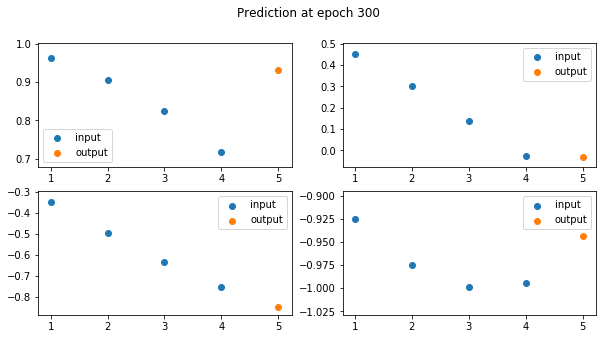

Loss at epoch 600: 0.012


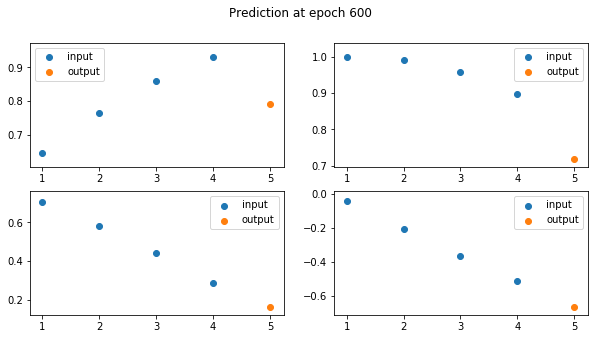

Loss at epoch 900: 0.024


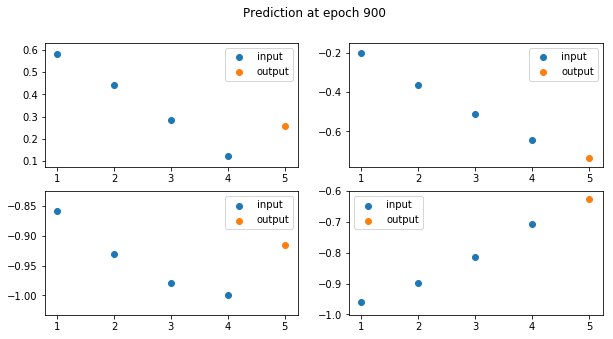

Loss at epoch 1200: 0.016


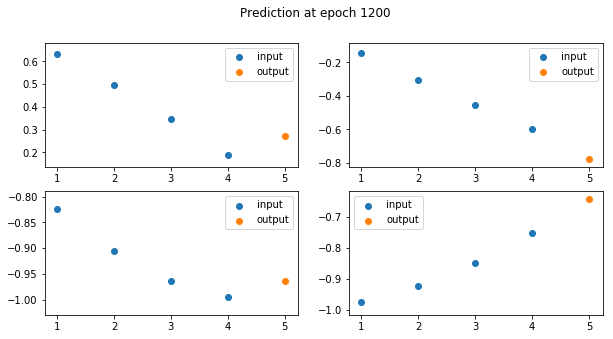

Loss at epoch 1500: 0.005


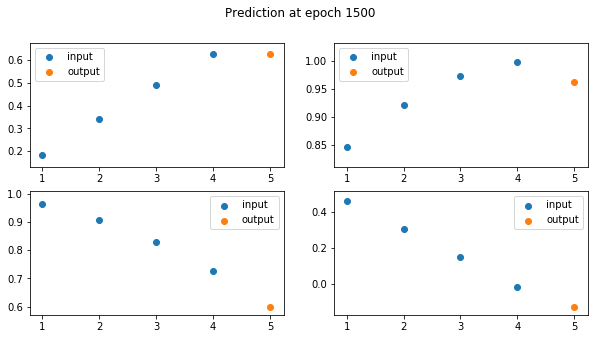

Loss at epoch 1800: 0.004


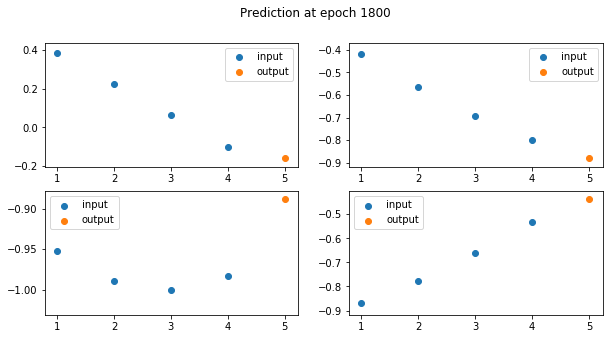

Loss at epoch 2100: 0.001


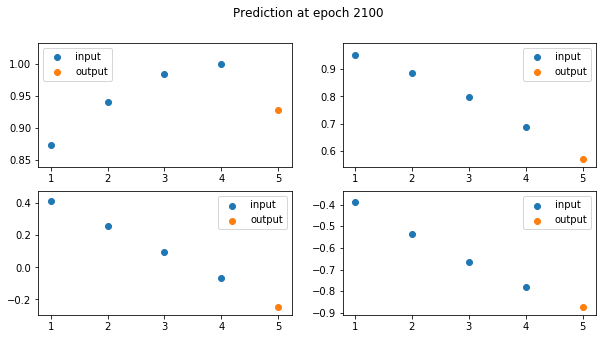

Loss at epoch 2400: 0.002


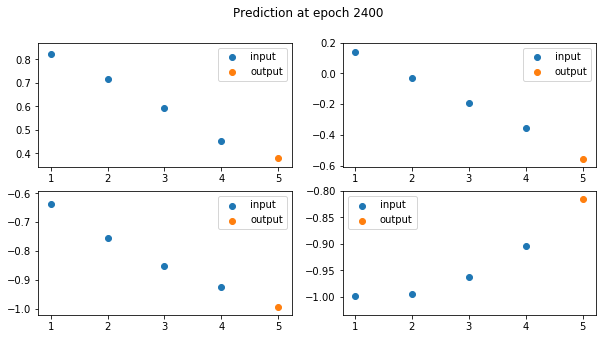

Loss at epoch 2700: 0.000


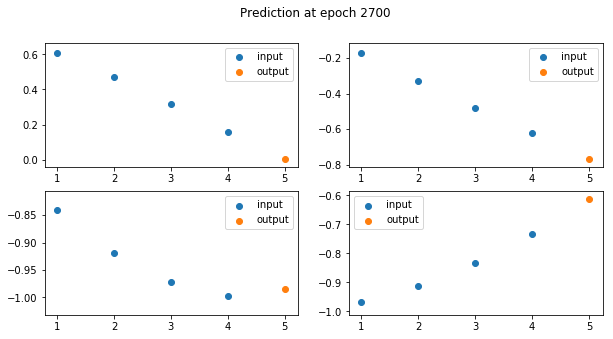

Loss at epoch 3000: 0.000


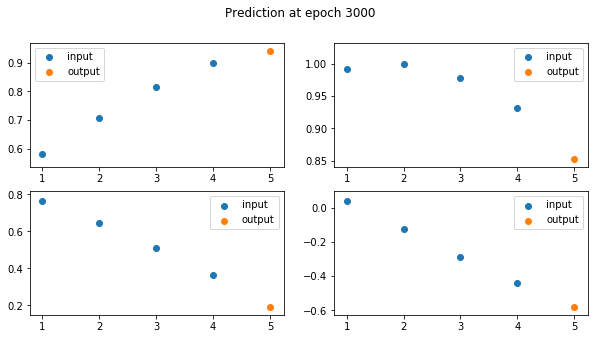

In [0]:
epochs = 3000
num_points = 20
seq_length = 4
batch_size = 1
input_size = 4
output_size = 1
rnn = RNN(input_size=input_size,
          output_size=output_size,
          hidden_size=10,
          n_layers=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters())

hidden = None

show_every = 300

for e in range(1, epochs+1):
  t, x = gen_data(num_points)
  
  x = x.view(seq_length,input_size+1)

  x_t = x[:, :-1].view(batch_size, seq_length, input_size)
  x_r = x[:,-1].view(batch_size, seq_length, output_size)

  
  hidden = hidden.detach() if hidden is not None else None
  
  x_p, hidden = rnn(x_t, hidden)
  
  loss = criterion(x_p, x_r)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  
  if e%show_every==0:
    print(F'Loss at epoch {e}: {loss.item():.3f}')
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Prediction at epoch {e}')
    plt.subplot(221)
    plt.scatter([1,2,3,4], x_t[0,0,:].view(-1).numpy(), label='input')
    plt.scatter([5], x_p.data[:,0,:].numpy(), label='output')
    plt.legend()
    plt.subplot(222)
    plt.scatter([1,2,3,4], x_t[0,1,:].view(-1).numpy(), label='input')
    plt.scatter([5], x_p.data[:,1,:].numpy(), label='output')
    plt.legend()
    plt.subplot(223)
    plt.scatter([1,2,3,4], x_t[0,2,:].view(-1).numpy(), label='input')
    plt.scatter([5], x_p.data[:,2,:].numpy(), label='output')
    plt.legend()
    plt.subplot(224)
    plt.scatter([1,2,3,4], x_t[0,3,:].view(-1).numpy(), label='input')
    plt.scatter([5], x_p.data[:,3,:].numpy(), label='output')
    plt.legend()
    plt.show()
 
    
  
  
  
  
  